In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torchvision
import numpy as np
from nilearn import plotting
import clinicadl
import pandas as pd
import matplotlib.pyplot as plt
from torchsummary import summary
from sklearn.metrics import log_loss
from collections import OrderedDict
from PIL import Image
from tqdm import tqdm
from math import floor
import random
import time

# torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# clinicaDL
from clinicadl.tools.tsv.data_split import create_split
from clinicadl.tools.deep_learning.data import generate_sampler, return_dataset, MRIDataset, MRIDatasetImage, MRIDatasetSlice, get_transforms
from torch.utils.data import DataLoader
from clinicadl.tools.deep_learning.cnn_utils import train, get_criterion, test
from clinicadl.tools.deep_learning.models.random import RandomArchitecture
from clinicadl.tools.deep_learning import EarlyStopping

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

# visualization
from scipy.ndimage import zoom
import itkwidgets
from ipywidgets import interact, interactive, IntSlider, ToggleButtons
import matplotlib.pyplot as plt

%matplotlib inline

/network/lustre/dtlake01/aramis/users/sasha.collin/miniconda3/envs/venv/lib/python3.7/site-packages/nilearn/datasets/__init__.py:90: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [3]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
from tools.explanations.evaluation import *
from tools.explanations.GradCam import *
from train.train_CNN import *
from tools.callbacks import *
from tools.data import *
from tools.explanations.visualization import *
from tools.models.CN5_FC3_3D import *

In [5]:
data_path = '/network/lustre/dtlake01/aramis/datasets/adni/caps/caps_v2021.tsv'
summary_path = '/network/lustre/dtlake01/aramis/datasets/adni/caps/caps_v2021_summary.tsv'
df_data = pd.read_csv(data_path,sep='\t',nrows=10)
df_summary = pd.read_csv(summary_path,sep='\t',nrows=10)

In [6]:
file = '/network/lustre/dtlake01/aramis/datasets/adni/caps/caps_v2021/subjects/sub-ADNI052S1251/ses-M00/deeplearning_prepare_data/image_based/t1_linear/sub-ADNI052S1251_ses-M00_T1w_space-MNI152NLin2009cSym_desc-Crop_res-1x1x1_T1w.pt'
ts = torch.load(file)
ts.shape

torch.Size([1, 169, 208, 179])

In [7]:
input_type = ''
network_type = ''
caps_directory = ''
preprocessing = ''
tsv_path = ''

# Iterator

# Train Single CNN

## Initialization

In [8]:
# global parameters
caps_directory = '/network/lustre/dtlake01/aramis/datasets/adni/caps/caps_v2021/'
batch_size = 4
num_workers = 1
loss = 'default'
optimizer_name = 'Adam'
learning_rate = 1e-4
weight_decay = 1e-4

In [9]:
# fold iterator
fold_iterator = range(2)

# load dataframes
AD = pd.read_csv('subjects/AD.tsv',sep='\t')
CN = pd.read_csv('subjects/CN.tsv',sep='\t')

# remove samples with NaN
AD.drop(AD[AD.isna().sum(axis=1) > 0].index, inplace=True)
CN.drop(CN[CN.isna().sum(axis=1) > 0].index, inplace=True)

# split data between training and validation sets
training_df, valid_df = create_split('AD', AD, 'diagnosis',0.2)
df_CN = create_split('CN', CN, 'diagnosis',0.2)
training_df = training_df.append(df_CN[0]).reset_index()#.iloc[np.array([0,1,2,-1,-2,-3])]
valid_df = valid_df.append(df_CN[1]).reset_index()#.iloc[np.array([0,1,2,-1,-2,-3])]

# drop index column
training_df.drop(columns = ['index'], inplace=True)
valid_df.drop(columns = ['index'], inplace=True)

train_transforms, all_transforms = get_transforms('image', minmaxnormalization=True, data_augmentation=None )
# fetch volumetric data
df_add_data = fetch_add_data(training_df)

# all_transforms = torchvision.transforms.Compose([])

DEBUG:root:p_age=0.40, p_sex=0.9672
DEBUG:root:p_age=0.26, p_sex=0.8667
DEBUG:root:p_age=0.99, p_sex=0.8941
INFO:root:Split for diagnosis AD was found after 3 trials
DEBUG:root:p_age=0.51, p_sex=0.8558
DEBUG:root:p_age=0.35, p_sex=0.9954
DEBUG:root:p_age=0.04, p_sex=0.9954
DEBUG:root:p_age=0.97, p_sex=0.8212
INFO:root:Split for diagnosis CN was found after 4 trials


In [10]:
data_train = MRIDatasetImage(caps_directory, training_df, df_add_data=df_add_data,all_transformations=all_transforms) #train_transformations=all_transforms
data_valid = MRIDatasetImage(caps_directory, valid_df, df_add_data=df_add_data, all_transformations=all_transforms) #train_transformations=all_transforms,


# sampler
train_sampler = generate_sampler(data_train)
valid_sampler = generate_sampler(data_valid)
# loaders
train_loader = DataLoader(data_train,
                         batch_size=batch_size,
                         sampler=train_sampler,
                         num_workers=num_workers,
                         pin_memory=True)

valid_loader = DataLoader(data_valid,
                         batch_size=batch_size,
                         sampler=valid_sampler,
                         num_workers=num_workers,
                         pin_memory=True)

## Training

In [11]:
# get sample
sample = data_train[0]
# build model
model = Net(sample, [8, 16, 32, 64, 128])
if torch.cuda.is_available():
    print("To cuda")
    model.cuda()
model.summary()

To cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1     [-1, 8, 167, 206, 177]             224
              ReLU-2     [-1, 8, 167, 206, 177]               0
       BatchNorm3d-3     [-1, 8, 167, 206, 177]              16
         MaxPool3d-4       [-1, 8, 83, 103, 88]               0
            Conv3d-5      [-1, 16, 81, 101, 86]           3,472
              ReLU-6      [-1, 16, 81, 101, 86]               0
       BatchNorm3d-7      [-1, 16, 81, 101, 86]              32
         MaxPool3d-8       [-1, 16, 40, 50, 43]               0
            Conv3d-9       [-1, 32, 38, 48, 41]          13,856
             ReLU-10       [-1, 32, 38, 48, 41]               0
      BatchNorm3d-11       [-1, 32, 38, 48, 41]              64
        MaxPool3d-12       [-1, 32, 19, 24, 20]               0
           Conv3d-13       [-1, 64, 17, 22, 18]          55,360
             ReLU-14       [-1,

In [29]:
nb_epochs = 20
# optimizer
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
# device
cuda = torch.device('cuda')
# record losses
train_losses = {
    'classification': np.zeros(nb_epochs),
    'volumes': np.zeros(nb_epochs),
    'age': np.zeros(nb_epochs),
    'sex': np.zeros(nb_epochs),
    'train': np.zeros(nb_epochs)
}
test_losses = {
    'classification': np.zeros(nb_epochs),
    'volumes': np.zeros(nb_epochs),
    'age': np.zeros(nb_epochs),
    'sex': np.zeros(nb_epochs),
    'test': np.zeros(nb_epochs)
}

# callbacks
ES = EarlyStopping(patience=5)
MC = ModelCheckpoint()

# training
for epoch in range(nb_epochs):
    update_dict(train_losses, train(epoch, model, optimizer, cuda, train_loader), epoch)
    update_dict(test_losses, test(model, cuda, valid_loader), epoch)
    if ES.step(train_losses['train'][epoch]):
        break
    MC.step(train_losses['train'][epoch], epoch, model, optimizer) # path

# save training curves
def save_loss(loss, name="loss"):
    df = pd.DataFrame.from_dict(loss)
    df[df.any(axis=1)].to_csv(name + '.csv',index=False)
    
save_loss(train_losses, 'train_losses')
save_loss(test_losses, 'val_losses')


5it [00:25,  5.03s/it]


KeyboardInterrupt: 

In [46]:
for k in range(1,5):
    print(np.linalg.norm(getattr(getattr(model,'branch' + str(k)), 'b' + str(k) + '-conv').weight.grad.data.cpu()))

38.70608
62.221134
338.53052
32.400326


## Visualization

In [44]:
def plot_losses(dict_losses, title=""):
    """
    Plot the different losses.
    
    Args:
        dict_losses: dictionnary of losses
    """
    plt.figure()
    plt.title(title)
    for key in dict_losses.keys():
        plt.plot(dict_losses[key], label=key)
    plt.legend()
    plt.show()
    
def plot_tensor(X):
    x = np.transpose(X[0], (1,2,0))
    x = (x-x.min())/x.max()
    plt.imshow(x)

In [17]:
plot_losses(train_losses, "Training losses")

NameError: name 'train_losses' is not defined

## Assess explanation

In [135]:
# load model
saved_data = torch.load('model_3D_2')

model.load_state_dict(saved_data['model_state_dict'])

<All keys matched successfully>

In [217]:
class CamExtractor():
    """
    Extracts cam features from the model
    """

    def __init__(self, model, target_layer=None):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None

    def save_gradient(self, grad):
        self.gradients = grad

    def forward_pass_on_convolutions(self, x, branch=None):
        """
        Does a forward pass on convolutions, hooks the function at given layer
        """
        conv_output = None
        if self.target_layer is not None:
            for module_pos, module in self.model.features._modules.items():
                x = module(x)  # Forward
                if module_pos == self.target_layer:
                    x.register_hook(self.save_gradient)
                    conv_output = x  # Save the convolution output on that layer
        else:
            if branch is None:
                raise Exception("Either target_layer or branch must not be None.")
            x = self.model.features(x)
            module_pos, module = next(iter(getattr(self.model, branch)._modules.items()))
            x = module(x)
            x.register_hook(self.save_gradient)
            conv_output = x

        return conv_output, x

    def forward_pass(self, x, branch=None):
        """
        Does a full forward pass on the model
        """
        # Forward pass on the convolutions
        conv_output, x = self.forward_pass_on_convolutions(x, branch)
        if self.target_layer is not None:
            # x = x.view(x.size(0), -1)  # Flatten
            # Forward pass on the classifier
            x = getattr(self.model, branch)(x)
        else:
            for k, (module_pos, module) in enumerate(getattr(self.model, branch)._modules.items()):
                if k != 0:
                    # do not apply again last convolution
                    x = module(x)  # Forward
        return conv_output, x


class GradCam():
    """
        Produces class activation map
    """

    def __init__(self, model, target_layer=None):
        self.model = model
        self.model.eval()
        # Define extractor
        self.extractor = CamExtractor(self.model, target_layer)
        if torch.cuda.is_available():
            self.null_scalar = torch.cuda.FloatTensor((1,)).fill_(0.)
        else:
            self.null_scalar = torch.FloatTensor((1,)).fill_(0.)

    def generate_cam(self, input_image, branch='branch1', resize=False, to_cpu=False):
        """
        Args:
            input_image: array
            branch: string, name of the branch
            resize: bool, if True, resize attention maps to input_image shape
        """
        while len(input_image.shape) < 5:
            input_image = input_image[None, ...]
        # Full forward pass
        # conv_output is the output of convolutions at specified layer
        # model_output is the final output of the model (1, 1000)
        if torch.cuda.is_available():
            input_image = input_image.cuda()
        conv_output, model_output = self.extractor.forward_pass(input_image, branch)
        # Zero grads
        self.model.features.zero_grad()
        getattr(self.model, branch).zero_grad()
        # Backward pass with specified target
        model_output.sum().backward(retain_graph=True)
        # Get hooked gradients
        guided_gradients = self.extractor.gradients.data[0]
        # Get convolution outputs
        target = conv_output.data[0]
        # Get weights from gradients
        weights = guided_gradients.mean(axis=(1, 2, 3))  # Take averages for each gradient
        # Multiply each weight with its conv output and then, sum
        cam = (weights.view(weights.shape + (1, 1, 1)) * target).sum(axis=0)
        cam = torch.where(cam > self.null_scalar, cam, self.null_scalar)
        cam = (cam - cam.min()) / (cam.max() - cam.min())  # Normalize between 0-1
        # resize to shape of input image
        if resize:
            cam = zoom(cam.cpu(), input_image.shape[-3:] / np.array(cam.shape))
        if to_cpu:
            cam.cpu()
        return cam

    def get_explanations(self, input_image, resize=False, to_cpu=False):
        """
        Generate Grad-CAM attention maps for all branches.
        Args:
            input_image: 3D-tensor. 4D-tensor (channel included) and 5D-tensor
                (batch size dimension included) with dim 1 are also accepted.
            resize: bool, if True, resize attention maps to input_image shape
        """
        if torch.cuda.is_available():
            input_image = input_image.cuda()
        # grad-cam attention maps
        cams = {}
        branches = ['branch' + str(k) for k in range(1, 5)]
        for branch in branches:
            cams[branch] = self.generate_cam(input_image, branch=branch, resize=resize, to_cpu=to_cpu)
        return cams

In [209]:
a0 = time.time()
GC = GradCam(model.cuda())
img = sample['image'].float()
attentions = GC.get_explanations(img.cuda(), resize=False, to_cpu=True)
#GC.visualize_cams(img)
print(time.time() - a0)

9.89321517944336


In [144]:
# for key in attentions:
#     attentions[key] = attentions[key].cpu()
visualize_explanations(img, attentions)

Image shape: 169 208 179


interactive(children=(IntSlider(value=103, description='layer', max=207), IntSlider(value=0, description='chan…

In [162]:
a,b,c,d = [], [], [], []
n_max = 500
step = 20
for k in tqdm(range(1, n_max, step)):
    np.random.seed(0)
    random.seed(0)
    torch.manual_seed(0)
    resu = max_sensitivity(img, GC, k)
    a.append(resu['branch1'])
    b.append(resu['branch2'])
    c.append(resu['branch3'])
    d.append(resu['branch4'])

  0%|          | 0/25 [00:00<?, ?it/s]

hello
hello
hello
hello
hello2


  4%|▍         | 1/25 [00:33<13:25, 33.55s/it]

hello3
hello
hello


  4%|▍         | 1/25 [00:50<20:08, 50.34s/it]


KeyboardInterrupt: 

In [218]:
t = time.time()
max_sensitivity(img, GC, N=1)
print(time.time() - t)

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [214]:
def max_sensitivity(X, exp_method, N=10, alpha=1):
    """
    Max-Sensitivity measures the reliability in terms of the maximum change in an explanation.
    Args:
        X: tensor, brain image
        exp_method: explanation method. Must have a get_explanations(self, input_image) attribute function
            which takes an image as input and returns a dictionary mapping branches to explanation maps
        N: number of iterations
        alpha: float, multiplicative parameter of the std of the gaussian law used to sample noise
    """
    if torch.cuda.is_available():
        X = X.cuda()

    max_diff = dict()
    # explanations for original image
    expls = exp_method.get_explanations(X, to_cpu=True)
    for _ in range(N):
        # create noisy image
        noisy_X = X + torch.normal(0, alpha * X.std(), size=X.size(),device=torch.device('cuda:0'))
        noisy_X = torch.max(noisy_X, X.min().expand_as(X))
        noisy_X = torch.min(noisy_X, X.max().expand_as(X))
        noisy_expls = exp_method.get_explanations(noisy_X, resize=False, to_cpu=True)
        # compute differences in explanations
        for target in noisy_expls:
            diff = np.linalg.norm(noisy_expls[target] - expls[target]) / np.linalg.norm(expls[target])
            if target not in max_diff:
                max_diff[target] = diff
            else:
                max_diff[target] = max(max_diff[target], diff)
        # tensor version
        # for target in noisy_expls:
        #     diff = torch.linalg.norm(noisy_expls[target] - expls[target]).item() / torch.linalg.norm(expls[target]).item()
        #     if target not in max_diff:
        #         max_diff[target] = diff
        #     else:
        #         max_diff[target] = max(max_diff[target], diff)
    return max_diff

In [210]:
def max_sensitivity(X, exp_method, N=10, alpha=1):
    """
    Max-Sensitivity measures the reliability in terms of the maximum change in an explanation.
    Args:
        X: tensor, brain image
        exp_method: explanation method. Must have a get_explanations(self, input_image) attribute function
            which takes an image as input and returns a dictionary mapping branches to explanation maps
        N: number of iterations
        alpha: float, multiplicative parameter of the std of the gaussian law used to sample noise
    """
    if torch.cuda.is_available():
        X = X.cuda()

    max_diff = dict()
    print('hello')
    # explanations for original image
    expls = exp_method.get_explanations(X, resize=False)
    for _ in range(N):
        # create noisy image
        print('hello')
        noisy_X = X + torch.normal(0, alpha * X.std(), size=X.size(),device=torch.device('cuda:0'))
        #X.data.new(X.size()).normal_(0, alpha * X.std().item()).cuda()
        print('hello')
        noisy_X = torch.max(noisy_X, X.min().expand_as(X))
        noisy_X = torch.min(noisy_X, X.max().expand_as(X))
        print('hello')
        noisy_expls = exp_method.get_explanations(noisy_X, resize=False)
        print('hello2')
        # compute differences in explanations
        for target in noisy_expls:
            diff = torch.linalg.norm(noisy_expls[target] - expls[target]) / torch.linalg.norm(expls[target])
            if target not in max_diff:
                max_diff[target] = diff
            else:
                max_diff[target] = max(max_diff[target], diff)
        print('hello3')
    return max_diff

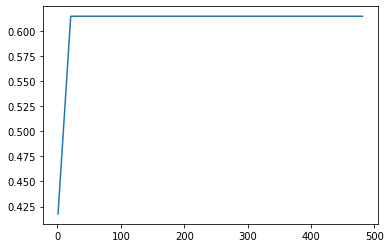

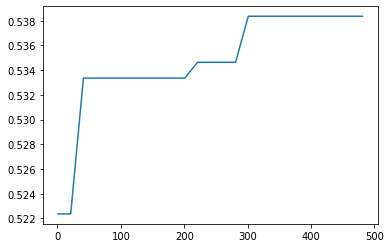

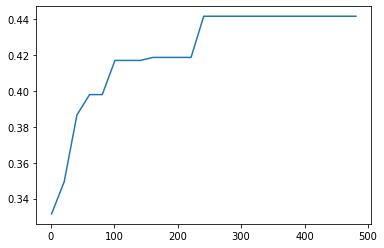

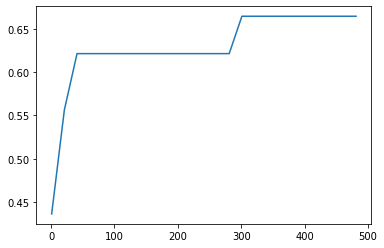

In [65]:
for elem in (a, b, c ,d):
    plt.figure()
    plt.plot(np.arange(1,n_max,step), elem)

In [23]:
attention = GC.generate_cam(img)

In [26]:
ids = np.unravel_index(np.argsort(-attention, axis=None), attention.shape)

In [98]:
at2 = attention.copy()
at2[(ids[0][:5000], ids[1][:5000])] = 0

In [48]:
batch_size2 = 10

In [49]:
img2 = img.tile(dims=(batch_size2,1,1,1))

In [50]:
img2.shape

torch.Size([10, 3, 208, 179])

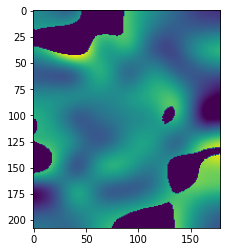

In [100]:
for k in range(batch_size2):
    img2[k,]

In [63]:
img2 = img[0,0,...]
img2[(ids[0][:5000], ids[1][:5000])] = 0

In [71]:
img2[(ids[0][:5000], ids[1][:5000])].shape

torch.Size([5000])

In [ ]:
def MoRF(X, model, exp_method, K=10, AUC=False, batch_size=512):
    """
    Most relevant first: measures the reliability of an explanation by testing 
    how fast the output decreases, while we progressively remove information (e.g., perturb pixels) 
    from the input 𝑥𝑥 (e.g., image), that appears as the most relevant by the explanation.
    Args:
        X: tensor, brain image, with shape (1, n_channels, **dims)
        exp_method: explanation method. Must have a get_explanations(self, input_image) attribute function
            which takes an image as input and returns a dictionary mapping branches to explanation maps
        K: number of relevant pixels to remove
        AUC: bool. If True: compute and return area under the curve obtained after removing successively 
            the K most relevant pixels.
            
    TO DO:
        - add several methods to perturb pixels
    """
    if torch.cuda.is_available():
        X = X.cuda()

    # explanations for original image
    expls = exp_method.get_explanations(X)
    
    # Indices of the sorted elements of the explanations:
    ind = dict()
    for target in expls:
        ind = np.unravel_index(np.argsort(-expls[target], axis=None), expls.shape)
    
        if AUC:
            pass
        else:
            # compute MoRF removing the K most relevant pixels
            MoRF
            perturbed_X = X.copy()
            perturbed_X[:,:,ind[0][:K],ind[1][:K]] = 0
            
        

# random

In [12]:
losses = pd.read_csv('train_losses_3D_2.csv')
test_losses = pd.read_csv('val_losses_3D_2.csv')

In [13]:
losses

,disease,volumes,age,sex,train
0,100.886792,208.577956,203.672194,108.274373,621.411314
1,99.300285,189.136253,181.978068,102.553474,572.968082
2,99.611135,177.060827,179.713241,96.790141,553.175344
3,98.597355,175.775614,161.555070,91.401181,527.329220
4,99.769326,169.524786,174.342649,90.024557,533.661319
5,91.561733,163.977378,162.120004,87.552520,505.211633
6,94.134592,155.408946,162.077803,82.099967,493.721307
7,97.508589,161.753081,167.885044,89.548769,516.695483
8,93.852117,153.788083,164.738980,83.998479,496.377658
9,94.444805,146.427590,164.837805,78.804526,484.514724


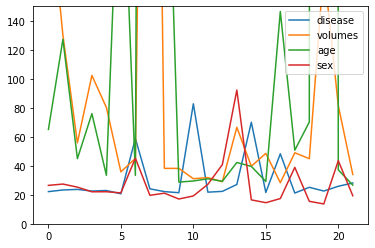

In [17]:
plt.plot(test_losses[['disease', 'volumes', 'age', 'sex']])
plt.ylim([0,150])
plt.legend(['disease', 'volumes', 'age', 'sex'])

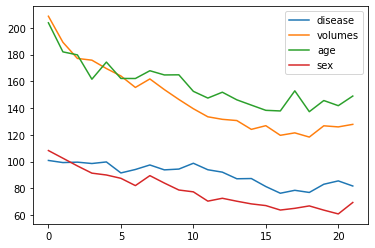

In [16]:
plt.plot(losses[['disease', 'volumes', 'age', 'sex']])
plt.legend(['disease', 'volumes', 'age', 'sex'])

# RANDOM

In [33]:
df_add_data[df_add_data.iloc[:,3].isna()].isna().sum(axis=0)

participant_id                                                                                      0
session_id                                                                                          0
sex                                                                                                 1
age                                                                                              1178
t1-volume_group-adni2021_atlas-Neuromorphometrics_ROI-Background_intensity                       1173
                                                                                                 ... 
t1-volume_group-adni2021_atlas-Neuromorphometrics_ROI-Right-Posterior-Orbital-Gyrus_intensity    1173
t1-volume_group-adni2021_atlas-Neuromorphometrics_ROI-Left-Planum-Polare_intensity               1173
t1-volume_group-adni2021_atlas-Neuromorphometrics_ROI-Right-Planum-Polare_intensity              1173
t1-volume_group-adni2021_atlas-Neuromorphometrics_ROI-Left-Precentral-Gyrus_intens

I am using working with the file '/network/lustre/dtlake01/aramis/datasets/adni/caps/caps_v2021.tsv' and using the 't1-volume' pipeline and the atlas 'AAL2'.
6267 samples (i.e. couples (participant_id, session_id)) do not have any volume value (i.e. NaN). 1 sample has no sex value and 1178 samples have no age values.


In [31]:
df_add_data.isna().sum(axis=0)

participant_id                                                                                      0
session_id                                                                                          0
sex                                                                                                 1
age                                                                                              1178
t1-volume_group-adni2021_atlas-Neuromorphometrics_ROI-Background_intensity                       6267
                                                                                                 ... 
t1-volume_group-adni2021_atlas-Neuromorphometrics_ROI-Right-Posterior-Orbital-Gyrus_intensity    6267
t1-volume_group-adni2021_atlas-Neuromorphometrics_ROI-Left-Planum-Polare_intensity               6267
t1-volume_group-adni2021_atlas-Neuromorphometrics_ROI-Right-Planum-Polare_intensity              6267
t1-volume_group-adni2021_atlas-Neuromorphometrics_ROI-Left-Precentral-Gyrus_intens

In [64]:

# initialize the model
convolutions = {
    'conv0':{
        'n_conv':1,
        'in_channels':None,
        'out_channels':16,
        'd_reduction': "MaxPooling"
    },
    'conv1':{
        'n_conv':1,
        'in_channels':None,
        'out_channels':32,
        'd_reduction': "MaxPooling"
    },
    'conv2':{
        'n_conv':1,
        'in_channels':None,
        'out_channels':32,
        'd_reduction': "MaxPooling"
    },
    'conv3':{
        'n_conv':1,
        'in_channels':None,
        'out_channels':64,
        'd_reduction': "MaxPooling"
    },
    'conv4':{
        'n_conv':1,
        'in_channels':None,
        'out_channels':128,
        'd_reduction': "MaxPooling"
    }
}
model = RandomArchitecture(convolutions,1,data_train.size)


# Define criterion and optimizer
criterion = get_criterion(loss)
optimizer = getattr(torch.optim, optimizer_name)(filter(lambda x: x.requires_grad, model.parameters()),
                                                   lr=learning_rate,
                                                   weight_decay=weight_decay)

In [8]:
class Options:
    def __init__(self):
        self.beginning_epoch = 0
        self.tolerance = 0
        self.patience = 10
        self.epochs = 10
        self.gpu = True
        self.batch_size = 1

In [9]:
train(model, train_loader, valid_loader, criterion, optimizer,False,'log_dir','model_dir', Options())

INFO:root:Beginning epoch 0.


KeyError: Caught KeyError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/network/lustre/dtlake01/aramis/users/sasha.collin/miniconda3/envs/venv/lib/python3.7/site-packages/pandas/core/indexes/base.py", line 3080, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas/_libs/index.pyx", line 70, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 101, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 1625, in pandas._libs.hashtable.Int64HashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 1632, in pandas._libs.hashtable.Int64HashTable.get_item
KeyError: 5

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/network/lustre/dtlake01/aramis/users/sasha.collin/miniconda3/envs/venv/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 185, in _worker_loop
    data = fetcher.fetch(index)
  File "/network/lustre/dtlake01/aramis/users/sasha.collin/miniconda3/envs/venv/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/network/lustre/dtlake01/aramis/users/sasha.collin/miniconda3/envs/venv/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/network/lustre/dtlake01/aramis/users/sasha.collin/miniconda3/envs/venv/lib/python3.7/site-packages/clinicadl/tools/deep_learning/data.py", line 566, in __getitem__
    participant, session, cohort, slice_idx, label = self._get_meta_data(idx)
  File "/network/lustre/dtlake01/aramis/users/sasha.collin/miniconda3/envs/venv/lib/python3.7/site-packages/clinicadl/tools/deep_learning/data.py", line 140, in _get_meta_data
    participant = self.df.loc[image_idx, 'participant_id']
  File "/network/lustre/dtlake01/aramis/users/sasha.collin/miniconda3/envs/venv/lib/python3.7/site-packages/pandas/core/indexing.py", line 889, in __getitem__
    return self._getitem_tuple(key)
  File "/network/lustre/dtlake01/aramis/users/sasha.collin/miniconda3/envs/venv/lib/python3.7/site-packages/pandas/core/indexing.py", line 1060, in _getitem_tuple
    return self._getitem_lowerdim(tup)
  File "/network/lustre/dtlake01/aramis/users/sasha.collin/miniconda3/envs/venv/lib/python3.7/site-packages/pandas/core/indexing.py", line 807, in _getitem_lowerdim
    section = self._getitem_axis(key, axis=i)
  File "/network/lustre/dtlake01/aramis/users/sasha.collin/miniconda3/envs/venv/lib/python3.7/site-packages/pandas/core/indexing.py", line 1124, in _getitem_axis
    return self._get_label(key, axis=axis)
  File "/network/lustre/dtlake01/aramis/users/sasha.collin/miniconda3/envs/venv/lib/python3.7/site-packages/pandas/core/indexing.py", line 1073, in _get_label
    return self.obj.xs(label, axis=axis)
  File "/network/lustre/dtlake01/aramis/users/sasha.collin/miniconda3/envs/venv/lib/python3.7/site-packages/pandas/core/generic.py", line 3739, in xs
    loc = index.get_loc(key)
  File "/network/lustre/dtlake01/aramis/users/sasha.collin/miniconda3/envs/venv/lib/python3.7/site-packages/pandas/core/indexes/base.py", line 3082, in get_loc
    raise KeyError(key) from err
KeyError: 5
